In [527]:
import os
import traceback

import pandas as pd
from certa.explain import CertaExplainer
from certa.local_explain import get_original_prediction, get_row
from certa.utils import merge_sources

from baselines.landmark import Landmark
from baselines.mojito import Mojito
import shap

import json
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_colwidth = 100

In [528]:
root_datadir = '../cheapER/datasets/'
experiments_dir = '../examples/'
dataset = 'amazon_google'
datadir = os.path.join(root_datadir, dataset)

In [529]:
lsource = pd.read_csv(datadir + '/tableA.csv')
rsource = pd.read_csv(datadir + '/tableB.csv')
gt = pd.read_csv(datadir + '/train.csv')
valid = pd.read_csv(datadir + '/valid.csv')
test = pd.read_csv(datadir + '/test.csv')

test_df = merge_sources(test, 'ltable_', 'rtable_', lsource, rsource, ['label'], [])
train_df = merge_sources(gt, 'ltable_', 'rtable_', lsource, rsource, ['label'], ['id'])

In [532]:
from models.utils import get_model
model_name = 'ditto'
save_path = 'models/saved/' + model_name + '/' + dataset 
model = get_model(model_name, save_path, datadir, dataset)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

working on amazon_google
reading data from ../cheapER/datasets/amazon_google
data loaded
loading model from models/saved/ditto/amazon_google


In [533]:
p, r, f1 = model.evaluation(test_df)
print(f1)

***** Eval results after epoch -1 *****
eval_loss: 0.6907387625049631
f1_score: 0.09671532846715329
report:               precision    recall  f1-score   support

           0       0.87      0.61      0.72      2059
           1       0.06      0.23      0.10       234

    accuracy                           0.57      2293
   macro avg       0.47      0.42      0.41      2293
weighted avg       0.79      0.57      0.65      2293

simple_accuracy: 0.5682511993022241
              precision    recall  f1-score   support

           0       0.87      0.61      0.72      2059
           1       0.06      0.23      0.10       234

    accuracy                           0.57      2293
   macro avg       0.47      0.42      0.41      2293
weighted avg       0.79      0.57      0.65      2293

0.1


In [534]:
def predict_fn(x):
    return model.predict(x)
def predict_fn_mojito(x):
    return model.predict(x, mojito=True)

In [535]:
certa_explainer = CertaExplainer(lsource, rsource)

In [536]:
predictions = model.predict(test_df)
predictions

,label,ltable_manufacturer,ltable_price,ltable_title,rtable_manufacturer,rtable_price,rtable_title,classes,labels,nomatch_score,match_score,ltable_id,rtable_id
0,0,microsoft software,5099.00,microsoft visual studio test agent 2005 cd 1 processor license,NaN,29.99,individual software professor teaches microsoft office 2007,0,0,0.503177,0.496823,393.0,831.0
1,0,adobe,399.00,adobe dreamweaver cs3 [ mac ],NaN,1659.99,adobe cs3 web premium,1,0,0.490775,0.509225,559.0,324.0
2,0,topics entertainment,29.99,instant immersion spanish 2.0,NaN,36.11,instant immers japanese dlx 2 .,0,0,0.501230,0.498770,558.0,3023.0
3,0,me-too-software,29.99,i transfer dvds 2 ipod edition ( win/mac ),NaN,20.95,ghost recon gold edition ( dvd-rom ),0,0,0.511169,0.488831,762.0,1618.0
4,0,adobe,199.00,adobe flash pro cs3 upgrade [ mac ],NaN,599.00,adobe illustrator cs3 ( mac ),1,0,0.488865,0.511135,1262.0,2860.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,0,topics entertainment,NaN,instant immersion german audio,NaN,27.57,instant immers french dlx 2,0,0,0.500414,0.499586,646.0,2501.0
2289,0,adobe,699.00,adobe flash pro cs3 [ mac ],NaN,18.88,38039295dm adobe flash cs3 professional v. 9 media tlp tlp nonprofit dvd mac,1,0,0.490123,0.509877,642.0,1927.0
2290,0,selectsoft publishing,19.95,let 's learn about time & date,NaN,28.99,it 's about time products learn the switch to mac,0,0,0.501780,0.498220,342.0,570.0
2291,0,nolo press,79.99,quicken legal business pro 2007,NaN,179.99,quickbooks ( r ) pro 2007,0,0,0.506908,0.493092,1241.0,3092.0


In [537]:
false_positives = predictions.loc[(predictions['label'] == 0) & (predictions['match_score'] > 0.5)]
false_negatives = predictions.loc[(predictions['label'] == 1) & (predictions['match_score'] < 0.5)]

In [538]:
import seaborn as sns
nm_cm = sns.light_palette("red", as_cmap=True)
m_cm = sns.light_palette("green", as_cmap=True)
cm = sns.light_palette("blue", as_cmap=True)

In [539]:
i = 0
rand_row =  false_positives.iloc[i]
l_id = int(rand_row['ltable_id'])
label = rand_row["label"]
l_tuple = lsource.iloc[l_id]
r_id = int(rand_row['rtable_id'])
r_tuple = rsource.iloc[r_id]
rand_row.head()
label = rand_row['label']

item = get_row(l_tuple, r_tuple)
n_item = item.drop(['ltable_id','rtable_id'],axis=1)
n_item.reindex(sorted(n_item.columns), axis=1)

,ltable_manufacturer,ltable_price,ltable_title,rtable_manufacturer,rtable_price,rtable_title
0,adobe,399.0,adobe dreamweaver cs3 [ mac ],NaN,1659.99,adobe cs3 web premium


In [540]:
original_prediction = false_negatives.iloc[i][['nomatch_score', 'match_score']]
original_prediction

nomatch_score    0.516137
match_score      0.483863
Name: 23, dtype: object

In [541]:
score = original_prediction[1]
score

0.48386255

In [542]:
pd.DataFrame(data=[[label, score]], columns=['label','score'])

,label,score
0,0,0.483863


In [543]:
pd.DataFrame(l_tuple).T

,id,title,manufacturer,price
559,559,adobe dreamweaver cs3 [ mac ],adobe,399


In [544]:
pd.DataFrame(r_tuple).T

,id,title,manufacturer,price
324,324,adobe cs3 web premium,NaN,1659.99


In [545]:
saliency_df, cf_summary, counterfactual_examples, triangles = certa_explainer.explain(l_tuple, r_tuple, predict_fn, num_triangles=10)

In [546]:
saliency_df.reindex(sorted(saliency_df.columns), axis=1).style.background_gradient(cmap=cm, axis=1, low=0.1, high=0.6)

,ltable_manufacturer,ltable_price,ltable_title,rtable_manufacturer,rtable_price,rtable_title
0,0.285714,0.285714,0.285714,0.514286,0.542857,1.000000


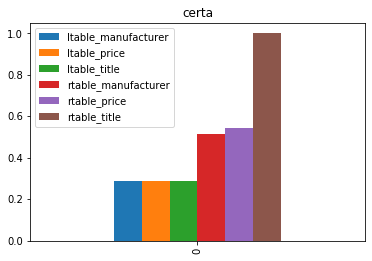

In [547]:
saliency_df.reindex(sorted(saliency_df.columns), axis=1).plot(kind='bar',title='certa')

In [548]:
landmark_explainer = Landmark(lambda x: predict_fn(x)['match_score'].values, test_df,
                              lprefix='',
                              exclude_attrs=['id', 'ltable_id', 'rtable_id', 'label'],
                              rprefix='',
                              split_expression=r' ')
labelled_item = item.copy()
labelled_item['label'] = int(label)
labelled_item['id'] = i
land_explanation = landmark_explainer.explain(labelled_item)
land_exp = land_explanation.groupby('column')['impact'].sum().to_dict()

In [549]:
pd.DataFrame(data=[land_exp.values()], columns=land_exp.keys()).reindex(sorted(land_exp.keys()), axis=1).style.background_gradient(cmap=cm, axis=1, low=0.2, high=0.6)

,ltable_manufacturer,ltable_price,ltable_title,rtable_manufacturer,rtable_price,rtable_title
0,0.000207,-0.001401,-0.011555,0.000587,-0.003492,-0.009630


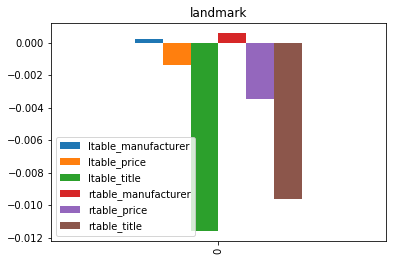

In [550]:
pd.DataFrame(data=[land_exp.values()], columns=land_exp.keys()).reindex(sorted(land_exp.keys()), axis=1).plot(kind='bar',title='landmark')

In [551]:
shap_explainer = shap.KernelExplainer(lambda x: predict_fn(x)['match_score'].values,
                                      train_df.drop(['label'], axis=1).astype(str)[:50],
                                      link='identity')
shap_instance = test_df.iloc[i, 1:].drop(['ltable_id', 'rtable_id']).astype(str)
shap_values = shap_explainer.shap_values(shap_instance, nsamples=100)
match_shap_values = shap_values
shap_saliency = dict()
for sv in range(len(match_shap_values)):
    shap_saliency[train_df.columns[1 + sv]] = match_shap_values[sv]


In [552]:
pd.DataFrame(data=[shap_saliency.values()], columns=shap_saliency.keys()).reindex(sorted(shap_saliency.keys()), axis=1).style.background_gradient(cmap=cm, axis=1, low=0.2, high=0.6)

,ltable_manufacturer,ltable_price,ltable_title,rtable_manufacturer,rtable_price,rtable_title
0,-0.000539,0.000190,0.002440,0.000410,-0.000433,-0.003299


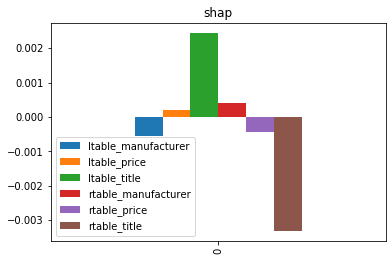

In [553]:
pd.DataFrame(data=[shap_saliency.values()], columns=shap_saliency.keys()).reindex(sorted(shap_saliency.keys()), axis=1).plot(kind='bar',title='shap')

In [554]:
mojito = Mojito(test_df.columns,
                attr_to_copy='left',
                split_expression=" ",
                class_names=['no_match', 'match'],
                lprefix='', rprefix='',
                feature_selection='lasso_path')
mojito_exp = mojito.drop(predict_fn_mojito, item,
                              num_features=30,
                              num_perturbation=100)
mojito_exp = mojito_exp.groupby('attribute')['weight'].mean().to_dict()
for f in item.columns:
    if not f in mojito_exp.keys():
        mojito_exp[f] = 0
if 'id' in mojito_exp:
    mojito_exp.pop('id', None)
if 'ltable_id' in mojito_exp:
    mojito_exp.pop('ltable_id', None)
if 'rtable_id' in mojito_exp:
    mojito_exp.pop('rtable_id', None)

Explaining 0/1


In [555]:
pd.DataFrame(data=[mojito_exp.values()], columns=mojito_exp.keys()).reindex(sorted(mojito_exp.keys()), axis=1).style.background_gradient(cmap=cm, axis=1, low=0.2, high=0.6)

,ltable_manufacturer,ltable_price,ltable_title,rtable_manufacturer,rtable_price,rtable_title
0,-0.000658,-0.000686,0.000126,0,0.000386,-0.001002


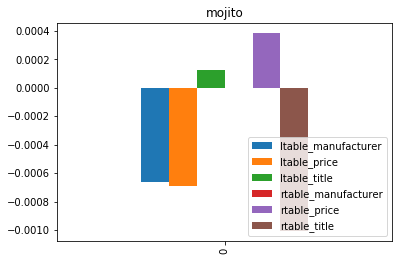

In [556]:
pd.DataFrame(data=[mojito_exp.values()], columns=mojito_exp.keys()).reindex(sorted(mojito_exp.keys()), axis=1).plot(kind='bar',title='mojito')

In [557]:
import random

null_hyp = dict()
for r in n_item.columns:
    null_hyp[r] = random.uniform(-1, 1)
null_hyp_saliency_df = pd.DataFrame(data=[null_hyp.values()], columns=null_hyp.keys())
null_hyp_saliency_df.reindex(sorted(null_hyp.keys()), axis=1).style.background_gradient(cmap=cm, axis=1, low=0.2, high=0.6)

,ltable_manufacturer,ltable_price,ltable_title,rtable_manufacturer,rtable_price,rtable_title
0,0.585154,-0.840685,0.757251,-0.900677,0.952211,-0.461468


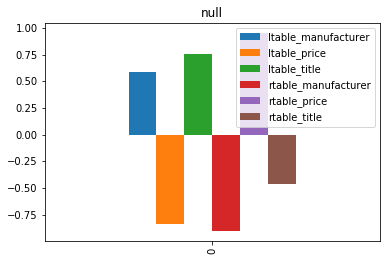

In [558]:
null_hyp_saliency_df.reindex(sorted(null_hyp.keys()), axis=1).plot(kind='bar',title='null')

In [559]:
certa_e = saliency_df.copy().to_dict(orient='list')
certa_e['type'] = 'certa'
mojito_e = mojito_exp.copy()
mojito_e['type'] = 'mojito'
land_e = land_exp.copy()
land_e['type'] = 'landmark'
shap_e = shap_saliency.copy()
shap_e['type'] = 'shap'
null_e = null_hyp.copy()
null_e['type'] = 'null'

In [560]:
def eig(explanation, agg=True):
    print(explanation)
    saliency = explanation.copy()
    exp_type = saliency['type']
    print(saliency.pop('type'))
    scores_d = []
    scores_c = []
    scores = []
    lt = l_tuple.copy()
    rt = r_tuple.copy()
    row = get_row(lt, rt)
    orig = predict_fn(row)[['nomatch_score', 'match_score']].values[0][1]
    for tk in np.arange(8):
        scores.append(orig)
        # get top k important attributes
        if not agg and tk >= len(saliency):
            break
        if exp_type == 'certa':
            if agg:
                explanation_attributes = sorted(saliency, key=saliency.get, reverse=True)[:tk]
            else:
                explanation_attributes = [sorted(saliency, key=saliency.get, reverse=True)[tk]]
        elif score < 0.5:
            saliency = {k:v for k,v in saliency.items() if v < 0}
            if agg:
                explanation_attributes = sorted(saliency, key=saliency.get)[:tk]
            else:
                explanation_attributes = [sorted(saliency, key=saliency.get)[tk]]
        else:
            saliency = {k:v for k,v in saliency.items() if v > 0}
            if agg:
                explanation_attributes = sorted(saliency, key=saliency.get, reverse=True)[:tk]
            else:
                explanation_attributes = [sorted(saliency, key=saliency.get, reverse=True)[tk]]
        print(explanation_attributes)
        # change those attributes
        try:
            lt = l_tuple.copy()
            rt = r_tuple.copy()
            modified_row = get_row(lt, rt)
            for e in explanation_attributes:
                modified_row[e] = ''
            modified_tuple_prediction = predict_fn(modified_row)[['nomatch_score', 'match_score']].values[0]
            #print(modified_tuple_prediction)
            #print(modified_row)
            score_drop = modified_tuple_prediction[1]
            
            scores_d.append(score_drop)
        except Exception as e:
            print(traceback.format_exc())
        try:
            lt = l_tuple.copy()
            rt = r_tuple.copy()
            modified_row = get_row(lt, rt)
            for e in explanation_attributes:
                if e.startswith(lprefix):
                    new_e = e.replace(lprefix, rprefix)
                else:
                    new_e = e.replace(rprefix, lprefix)
                modified_row[e] = modified_row[new_e]
            #print(modified_row)
            modified_tuple_prediction = predict_fn(modified_row)[['nomatch_score', 'match_score']].values[0]
            #print(modified_tuple_prediction)
            score_copy = modified_tuple_prediction[1]
            scores_c.append(score_copy)
        except Exception as e:
            print(traceback.format_exc())
    pd.Series(scores_d,name='drop').plot(kind='line', ylim=(0.45,0.55), title=exp_type)
    #pd.Series(scores_c,name='copy').plot(kind='line', ylim=(0.45,0.55), title=exp_type)
    pd.Series(scores,name='pred').plot(kind='line', ylim=(0.45,0.55), title=exp_type)

{'ltable_title': [0.2857142857142857], 'ltable_manufacturer': [0.2857142857142857], 'ltable_price': [0.2857142857142857], 'rtable_title': [0.9999999999999999], 'rtable_manufacturer': [0.5142857142857142], 'rtable_price': [0.5428571428571428], 'type': 'certa'}
certa
[]
['rtable_title']
['rtable_title', 'rtable_price']
['rtable_title', 'rtable_price', 'rtable_manufacturer']
['rtable_title', 'rtable_price', 'rtable_manufacturer', 'ltable_title']
['rtable_title', 'rtable_price', 'rtable_manufacturer', 'ltable_title', 'ltable_manufacturer']
['rtable_title', 'rtable_price', 'rtable_manufacturer', 'ltable_title', 'ltable_manufacturer', 'ltable_price']
['rtable_title', 'rtable_price', 'rtable_manufacturer', 'ltable_title', 'ltable_manufacturer', 'ltable_price']


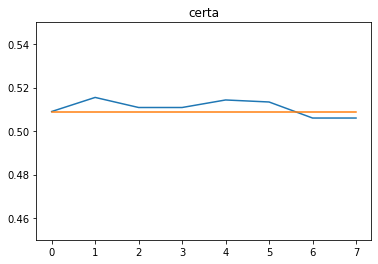

In [561]:
eig(certa_e, agg=True)